# Quantitative Spatial Economics 

## Tutorial Topic 7: Commuting Gravity Regression

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](dominik.bursy@icloud.com), 
[Lars Felder](lars.felder@fu-berlin.de), 
[Kate Bablyak](kateryna.bablyak@student.hu-berlin.de), 
[Marlon Krippendorf](marlon.krippendorf@fu-berlin.de)


Last Update: June 2025

---

Ahlfeldt, Gabriel M., Stephen J. Redding, Daniel M. Sturm, and Nikolaus Wolf. ‘The Economics of Density: Evidence From the Berlin Wall’. Econometrica 83, no. 6 (2015): 2127–89. https://doi.org/10.3982/ECTA10876.

---

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
from pathlib import Path
import os
# Traveltime x Travelcost
import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


---

## Estimate epsilon and kappa and recover the fundamentals

In [3]:
bezirke_file = f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/Bezirke23.shp'

# --- Load Bezirke ---
gdf_bezirke = gpd.read_file(bezirke_file).to_crs(3035)

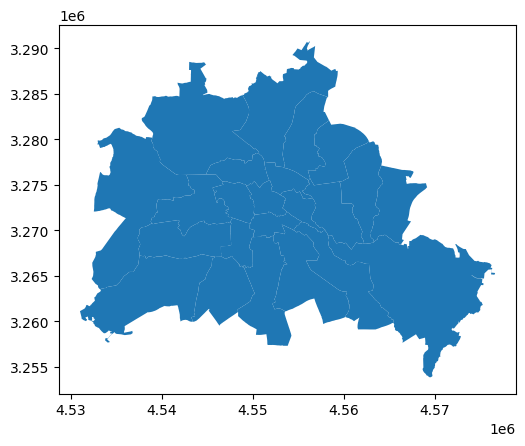

In [4]:
gdf_bezirke.plot();

In [5]:
df_commute = pd.read_stata('/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration/data/commutebezirk_all.dta')

In [6]:
df_tt_matrix = pd.read_csv('/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration/resources/TTMATRIX-main/Output/TTMATRIX_berlin_trainline.csv')
df_tt_matrix['STAT_BLOCK'] = df_tt_matrix['STAT_BLOCK'].str.replace(r'STAT_BLOCK', '', regex=True).astype(int)

In [7]:
df_tt_matrix

,STAT_BLOCK,STAT_BLOCK1001,STAT_BLOCK1005,STAT_BLOCK1007,STAT_BLOCK1009,STAT_BLOCK1010,STAT_BLOCK1012,STAT_BLOCK1013,STAT_BLOCK1044,STAT_BLOCK1072,...,STAT_BLOCK195619,STAT_BLOCK195621,STAT_BLOCK195622,STAT_BLOCK195623,STAT_BLOCK195624,STAT_BLOCK195626,STAT_BLOCK195627,STAT_BLOCK195629,STAT_BLOCK195630,STAT_BLOCK195631
0,1001,0.000000,11.274613,10.610993,12.642099,12.773646,13.866892,13.958380,16.494508,25.357655,...,77.997739,76.370107,77.594626,79.198553,80.709382,80.651445,77.590609,81.156120,74.478856,75.095737
1,1005,11.274613,0.000000,6.955277,3.129295,3.393018,10.211176,10.302664,7.113881,15.977028,...,68.617112,66.989480,68.213999,69.817926,71.328754,71.270817,68.209982,71.775492,65.098229,65.715109
2,1007,10.610993,6.955277,0.000000,8.322763,8.454310,5.748209,4.469736,12.175172,21.038319,...,73.678403,72.050771,73.275290,74.879217,76.390046,76.332109,73.271273,76.836784,70.159521,70.776401
3,1009,12.642099,3.129295,8.322763,0.000000,4.760504,11.578662,11.670150,8.481367,17.344514,...,69.984598,68.356966,69.581485,71.185412,72.696240,72.638303,69.577468,73.142978,66.465715,67.082595
4,1010,12.773646,3.393018,8.454310,4.760504,0.000000,11.710209,11.801697,4.085670,12.948817,...,67.736744,66.109112,67.333631,68.937558,70.448386,70.390449,67.329614,70.895124,64.217861,64.834741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12304,195626,80.651445,71.270817,76.332109,72.638303,70.390449,79.588008,79.679496,74.430865,68.223423,...,19.291194,15.419749,16.644268,18.248195,19.767848,0.000000,6.027789,23.387042,12.261360,14.145378
12305,195627,77.590609,68.209982,73.271273,69.577468,67.329614,76.527172,76.618660,71.370029,65.162588,...,16.230358,10.680564,11.905083,13.509010,16.611141,6.027789,0.000000,20.326206,6.233572,8.756904
12306,195629,81.156120,71.775492,76.836784,73.142978,70.895124,80.092683,80.184171,74.935540,68.728098,...,5.954233,18.525031,17.999541,17.612434,11.464087,23.387042,20.326206,0.000000,17.214454,17.831334
12307,195630,74.478856,65.098229,70.159521,66.465715,64.217861,73.415419,73.506908,68.258277,62.050835,...,13.118606,6.517547,7.712384,9.284106,13.499388,12.261360,6.233572,17.214454,0.000000,2.523332


In [8]:
block_file = f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/Berlin4matlab.shp'
gdf_berlin = gpd.read_file(block_file).to_crs(3035)

In [9]:
# gdf_berlin_tt = pd.concat([gdf_berlin ,df_tt_matrix], axis=1)
gdf_berlin_tt =  gdf_berlin.merge(df_tt_matrix, on='STAT_BLOCK')

In [10]:
gdf_berlin_tt_T = gdf_berlin_tt[list(['BEZIRK']) + list(gdf_berlin_tt.columns[9:])].groupby('BEZIRK').mean().T
gdf_berlin_tt_T.index = gdf_berlin_tt_T.index.str.replace(r'STAT_BLOCK', '', regex=True).astype(int)

In [11]:
gdf_berlin_tt_T_long = pd.concat([gdf_berlin_tt_T, gdf_berlin[['BEZIRK', 'STAT_BLOCK']].set_index('STAT_BLOCK')], axis=1)
gdf_berlin_tt_T_long = gdf_berlin_tt_T_long.groupby('BEZIRK').mean()

In [12]:
gdf_berlin_tt_T_long = pd.melt(gdf_berlin_tt_T_long.reset_index(), id_vars=['BEZIRK'])
gdf_berlin_tt_T_long.rename(columns={'BEZIRK': 'startbezirk', 'variable': 'endbezirk', 'value': 'time'}, inplace=True)

In [13]:
merged = pd.concat([gdf_berlin_tt_T_long, df_commute[['minutes', 'commute']]], axis=1)

In [14]:
merged

,startbezirk,endbezirk,time,minutes,commute
0,1,1,20.204772,16.190065,463.0
1,2,1,26.175962,28.193182,176.0
2,3,1,40.637626,30.253061,245.0
3,4,1,36.099728,30.561798,178.0
4,5,1,75.000266,43.869564,69.0
...,...,...,...,...,...
139,8,12,78.019926,43.250000,4.0
140,9,12,94.756303,56.666668,9.0
141,10,12,88.094909,54.285713,14.0
142,11,12,73.748028,53.250000,12.0


## * Gravity Estimation *

In [15]:
# Fill missing with zero (for fillin behavior)
merged["commute"] = merged["commute"].fillna(0)

# Total commuters
tot_commute = merged["commute"].sum()

# Commuting probability
merged["probcomm"] = merged["commute"] / tot_commute

# Log of probability
merged["lprobcomm"] = np.log(merged["probcomm"].replace(0, np.nan))


In [16]:
# Generate dummy (fixed effects) variables
start_dummies = pd.get_dummies(merged["startbezirk"], prefix="sbzk")
end_dummies = pd.get_dummies(merged["endbezirk"], prefix="ebzk")

# Combine into final dataset
gravity_df = pd.concat([merged, start_dummies, end_dummies], axis=1)


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define regression variables
X_cols = ['time'] + [col for col in gravity_df.columns if col.startswith('sbzk') or col.startswith('ebzk')]
X = gravity_df[X_cols]
X = sm.add_constant(X)
y = gravity_df['lprobcomm']

# OLS regression with robust standard errors
model1 = sm.OLS(y, X).fit(cov_type='HC1')  # HC1 ≈ STATA's robust
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:              lprobcomm   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     2544.
Date:                Thu, 05 Jun 2025   Prob (F-statistic):          9.12e-151
Time:                        15:13:05   Log-Likelihood:                -66.518
No. Observations:                 144   AIC:                             181.0
Df Residuals:                     120   BIC:                             252.3
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7175      0.130    -13.183      0.0

In [18]:
df2 = gravity_df[gravity_df["commute"] >= 10]
X2 = df2[X_cols]
X2 = sm.add_constant(X2)
y2 = df2["lprobcomm"]

model2 = sm.OLS(y2, X2).fit(cov_type='HC1')
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:              lprobcomm   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     2864.
Date:                Thu, 05 Jun 2025   Prob (F-statistic):          1.11e-128
Time:                        15:13:05   Log-Likelihood:                -24.296
No. Observations:                 122   AIC:                             96.59
Df Residuals:                      98   BIC:                             163.9
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7833      0.137    -13.038      0.0

In [21]:
## https://www.statsmodels.org/dev/gee.html#families

df3 = gravity_df[gravity_df["commute"] >= 10]

# GLM Poisson with robust SEs and fixed effects via categorical vars
model3 = smf.glm(
    formula="probcomm ~ time + C(startbezirk) + C(endbezirk)",
    data=df3,
    family=sm.families.Poisson(link=sm.families.links.log())
    # family=sm.families.Gaussian(link=sm.families.links.log())
).fit(cov_type='HC1')
print(model3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               probcomm   No. Observations:                  122
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.7691
Date:                Thu, 05 Jun 2025   Deviance:                     0.061215
Time:                        15:14:21   Pearson chi2:                   0.0658
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006529
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.7959 

In [20]:
model4 = smf.glm(
    formula="probcomm ~ time + C(startbezirk) + C(endbezirk)",
    data=df3,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit(cov_type='HC1')
print(model4.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               probcomm   No. Observations:                  122
Model:                            GLM   Df Residuals:                       98
Model Family:                   Gamma   Df Model:                           23
Link Function:                    log   Scale:                         0.10722
Method:                          IRLS   Log-Likelihood:                 614.31
Date:                Thu, 05 Jun 2025   Deviance:                       10.489
Time:                        15:13:05   Pearson chi2:                     10.5
No. Iterations:                    18   Pseudo R-squ. (CS):             0.9992
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1497 

---

Our Travel Time estimate for $\kappa \varepsilon$ is around 0.55

---

## References <a class="anchor" id="references"></a>

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- [https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)
- ...

---